## Descripción de la Estrategia

La estrategia de trading se simuló con un capital inicial de **1.000 USD**, utilizando compras sucesivas de hasta el **10% del equity disponible en cada señal**, con un límite de apalancamiento de **2x** sobre el capital total y aplicando una comisión del **1% por operación**.  
La regla de entrada establece que se realizan compras cuando la probabilidad del modelo **LSTM** supera el umbral de **0,45**, acumulando posiciones hasta el máximo permitido, mientras que se ejecuta la venta de todas las posiciones cuando la probabilidad cae por debajo de **0,35**.  

Durante el período analizado (2025), la estrategia generó un rendimiento acumulado superior al **50%**, frente al **15%** obtenido con un enfoque pasivo de *buy & hold*.  
En términos prácticos, esto significa que el modelo fue capaz de **capturar de forma más eficiente los tramos alcistas del mercado y salir en fases bajistas**, multiplicando por más de tres el resultado del *buy & hold*.


== KPIs estrategia (2025) ==
start: 2025-01-01
end  : 2025-08-30
n_days         : 242
n_trades       : 50
pct_days_in_mkt: 0.769
equity_final   : 1554.53
bh_final       : 1152.39
ret_strategy   : 55.45%
ret_buy_hold   : 15.24%
max_drawdown   : -29.98%
sharpe_252     : 1.086
fees_total     : 8.20 USD


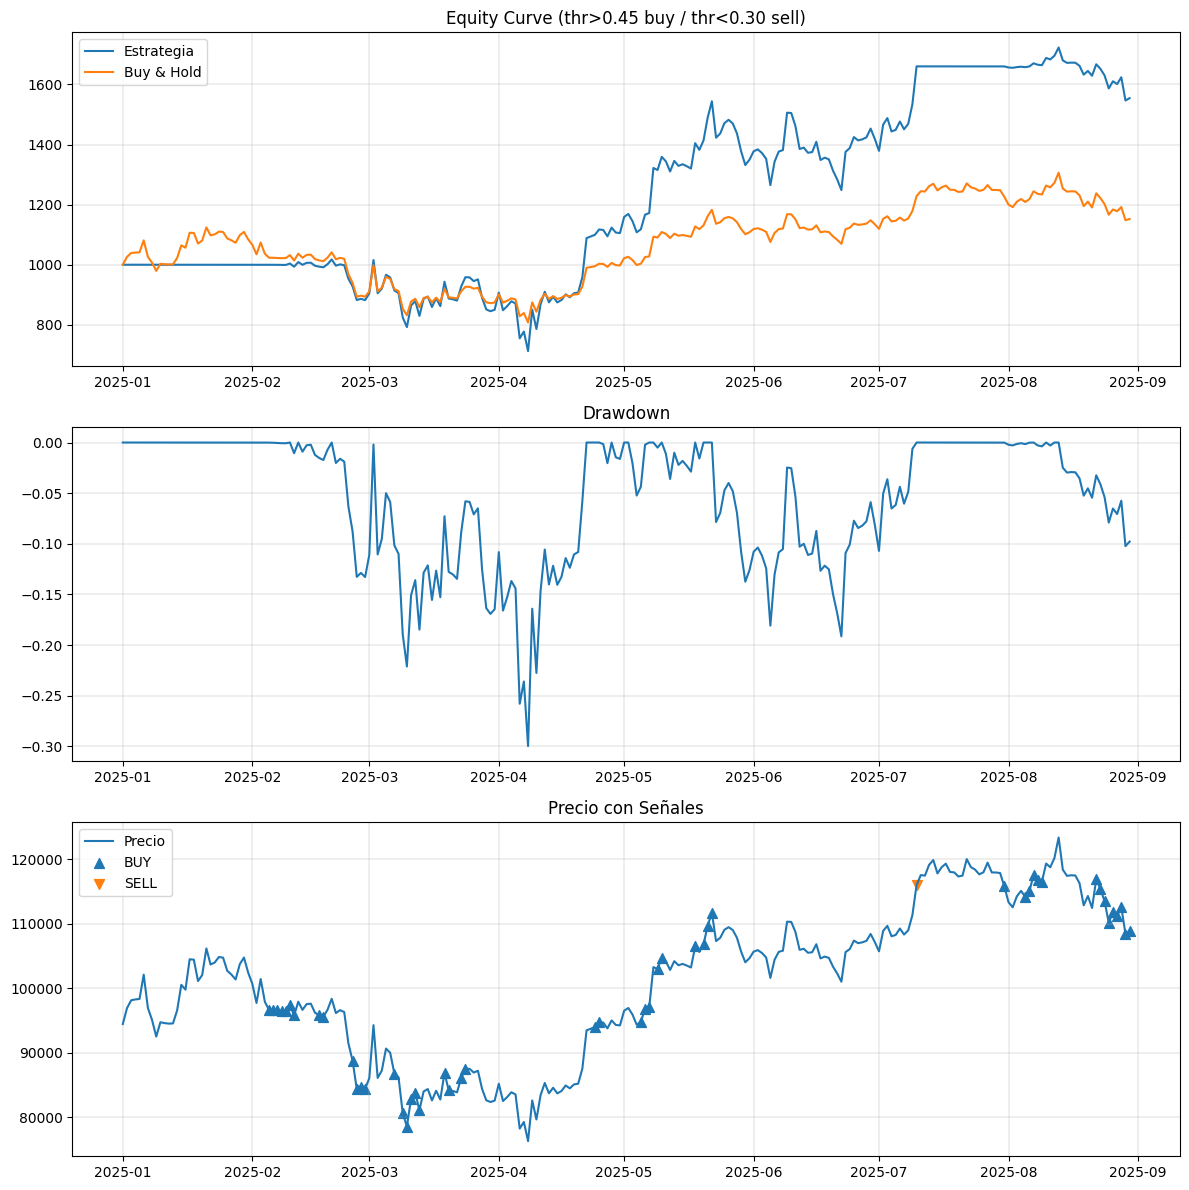


Guardado CSV de operaciones: data\backtest_ops_thr045_030.csv
Guardado PNG del reporte   : data\backtest_report_thr045_030.png


In [1]:
# ======================================================
# Backtesting visual (2025) con reglas:
# - Capital inicial: 1000 USD
# - Señal de compra: proba_lstm > 0.45  => comprar 10% equity
# - Señal de venta:  proba_lstm < 0.30  => vender TODA la posición
# - Apalancamiento máximo: 2x
# - Comisión: 0.1% por lado
# - Período: 2025
# ======================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------
# Parámetros
# --------------------
CSV_PATH = r"data\bt_unified_2025.csv"
DATE_COL = "Date"
PRICE_COL = "close"
PROBA_COL = "proba_lstm"

CAPITAL_INICIAL = 1000.0
LEVERAGE = 2.0
COMMISSION_BP = 10    # 0.1%
SLIPPAGE_BP = 0       # 0 si no quieres simular slippage

OUT_DIR = os.path.dirname(CSV_PATH)
OUT_TRADES = os.path.join(OUT_DIR, "backtest_ops_thr045_030.csv")
OUT_PNG = os.path.join(OUT_DIR, "backtest_report_thr045_030.png")

# --------------------
# Utilidades
# --------------------
def sharpe_252(ret_series):
    if ret_series.std(ddof=0) == 0 or len(ret_series) < 2:
        return np.nan
    return (np.sqrt(252) * ret_series.mean()) / ret_series.std(ddof=0)

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return float(dd.min()), dd

# --------------------
# Carga y preparación
# --------------------
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL)
df_2025 = df[df[DATE_COL].dt.year == 2025].copy()

if df_2025.empty:
    raise ValueError("No hay datos de 2025 en el CSV.")

# --------------------
# Simulación
# --------------------
cash = CAPITAL_INICIAL
btc_units = 0.0
equity_list, exposure_list = [], []
trade_log, fees_accum = [], 0.0

price0 = float(df_2025.iloc[0][PRICE_COL])
bh_units = CAPITAL_INICIAL / price0
bh_equity = []

for _, row in df_2025.iterrows():
    date = row[DATE_COL]
    price = float(row[PRICE_COL])
    proba = float(row[PROBA_COL])

    # Equity y exposición antes de operar
    position_value = btc_units * price
    equity = cash + position_value
    max_notional = LEVERAGE * equity if equity > 0 else 0.0
    buying_power = max(0.0, max_notional - position_value)
    desired_invest = 0.10 * equity if equity > 0 else 0.0

    buy_price = price * (1 + SLIPPAGE_BP/10000)
    sell_price = price * (1 - SLIPPAGE_BP/10000)

    # --- Reglas ---
    if proba > 0.45 and buying_power > 0 and desired_invest > 0:
        invest = min(desired_invest, buying_power)
        fee = invest * (COMMISSION_BP/10000)
        net_invest = invest - fee
        units = net_invest / buy_price
        btc_units += units
        cash -= invest
        fees_accum += fee
        position_value = btc_units * price
        equity = cash + position_value
        trade_log.append((date, "BUY", price, invest, fee, cash, btc_units, position_value))

    elif proba < 0.35 and btc_units > 0:
        gross = btc_units * sell_price
        fee = gross * (COMMISSION_BP/10000)
        proceeds = gross - fee
        cash += proceeds
        fees_accum += fee
        btc_units = 0.0
        position_value = 0.0
        equity = cash
        trade_log.append((date, "SELL", price, proceeds, fee, cash, btc_units, position_value))

    equity_list.append((date, equity))
    exposure_list.append((date, position_value))
    bh_equity.append((date, bh_units * price))

equity_df = pd.DataFrame(equity_list, columns=[DATE_COL, "equity"])
expo_df = pd.DataFrame(exposure_list, columns=[DATE_COL, "notional"])
bh_df = pd.DataFrame(bh_equity, columns=[DATE_COL, "bh_equity"])

res = df_2025[[DATE_COL, PRICE_COL]].merge(equity_df, on=DATE_COL).merge(bh_df, on=DATE_COL).merge(expo_df, on=DATE_COL)

# --------------------
# KPIs
# --------------------
equity_final = float(res.iloc[-1]["equity"])
total_ret = equity_final / CAPITAL_INICIAL - 1.0
bh_final = float(res.iloc[-1]["bh_equity"])
bh_ret = bh_final / CAPITAL_INICIAL - 1.0

res["ret"] = res["equity"].pct_change().fillna(0.0)
sharpe = sharpe_252(res["ret"])
mdd, dd_series = max_drawdown(res["equity"])
pct_days_in_market = float((res["notional"] > 0).mean())

trades_df = pd.DataFrame(trade_log, columns=[DATE_COL, "Action", "Price", "AmountUSD", "FeeUSD", "Cash", "BTC_units", "Notional"])
n_trades = len(trades_df)

print("== KPIs estrategia (2025) ==")
print(f"start: {res.iloc[0][DATE_COL].date()}")
print(f"end  : {res.iloc[-1][DATE_COL].date()}")
print(f"n_days         : {len(res)}")
print(f"n_trades       : {n_trades}")
print(f"pct_days_in_mkt: {pct_days_in_market:.3f}")
print(f"equity_final   : {equity_final:.2f}")
print(f"bh_final       : {bh_final:.2f}")
print(f"ret_strategy   : {total_ret*100:.2f}%")
print(f"ret_buy_hold   : {bh_ret*100:.2f}%")
print(f"max_drawdown   : {mdd*100:.2f}%")
print(f"sharpe_252     : {sharpe:.3f}")
print(f"fees_total     : {fees_accum:.2f} USD")

# --------------------
# Gráficos
# --------------------
fig = plt.figure(figsize=(12, 12))

ax1 = plt.subplot(3,1,1)
ax1.plot(res[DATE_COL], res["equity"], label="Estrategia")
ax1.plot(res[DATE_COL], res["bh_equity"], label="Buy & Hold")
ax1.set_title("Equity Curve (thr>0.45 buy / thr<0.30 sell)")
ax1.legend(); ax1.grid(True, linewidth=0.3)

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(res[DATE_COL], dd_series, label="Drawdown")
ax2.set_title("Drawdown")
ax2.grid(True, linewidth=0.3)

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(res[DATE_COL], res[PRICE_COL], label="Precio")
if not trades_df.empty:
    buys = trades_df[trades_df["Action"]=="BUY"]
    sells = trades_df[trades_df["Action"]=="SELL"]
    if not buys.empty:
        ax3.scatter(buys[DATE_COL], buys["Price"], marker="^", s=50, label="BUY")
    if not sells.empty:
        ax3.scatter(sells[DATE_COL], sells["Price"], marker="v", s=50, label="SELL")
ax3.set_title("Precio con Señales")
ax3.legend(); ax3.grid(True, linewidth=0.3)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
plt.show()

trades_df.to_csv(OUT_TRADES, index=False)
print(f"\nGuardado CSV de operaciones: {OUT_TRADES}")
print(f"Guardado PNG del reporte   : {OUT_PNG}")
